# EDA

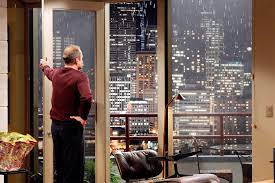

In [22]:
# Data processing packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from math import radians, cos, sin, asin, sqrt
import math

# Data Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats

# Interface packages
import psycopg2
import os
from dotenv import load_dotenv


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [23]:
# Import dataframe
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

cur = conn.cursor()
query_string = "select * from eda.king_county_house_details d inner join eda.king_county_house_sales s on s.house_id = d.id"
df = pd.read_sql(query_string, conn)
conn.close()

df.head(10)

id  bedrooms  bathrooms  sqft_living   sqft_lot  floors  \
0  7129300520     3.000      1.000     1180.000   5650.000   1.000   
1  6414100192     3.000      2.250     2570.000   7242.000   2.000   
2  5631500400     2.000      1.000      770.000  10000.000   1.000   
3  2487200875     4.000      3.000     1960.000   5000.000   1.000   
4  1954400510     3.000      2.000     1680.000   8080.000   1.000   
5  7237550310     4.000      4.500     5420.000 101930.000   1.000   
6  1321400060     3.000      2.250     1715.000   6819.000   2.000   
7  2008000270     3.000      1.500     1060.000   9711.000   1.000   
8  2414600126     3.000      1.000     1780.000   7470.000   1.000   
9  3793500160     3.000      2.500     1890.000   6560.000   2.000   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0         NaN 0.000          3      7    1180.000          0.000      1955   
1       0.000 0.000          3      7    2170.000        400.000      1951   
2       0.000 0.000          3      6     770.000          0.000      1933   
3       0.000 0.000          5      7    1050.000        910.000      1965   
4       0.000 0.000          3      8    1680.000          0.000      1987   
5       0.000 0.000          3     11    3890.000       1530.000      2001   
6       0.000 0.000          3      7    1715.000            NaN      1995   
7       0.000   NaN          3      7    1060.000          0.000      1963   
8       0.000 0.000          3      7    1050.000        730.000      1960   
9       0.000 0.000          3      7    1890.000          0.000      2003   

   yr_renovated  zipcode    lat     long  sqft_living15  sqft_lot15  \
0         0.000    98178 47.511 -122.257       1340.000    5650.000   
1     19910.000    98125 47.721 -122.319       1690.000    7639.000   
2           NaN    98028 47.738 -122.233       2720.000    8062.000   
3         0.000    98136 47.521 -122.393       1360.000    5000.000   
4         0.000    98074 47.617 -122.045       1800.000    7503.000   
5         0.000    98053 47.656 -122.005       4760.000  101930.000   
6         0.000    98003 47.310 -122.327       2238.000    6819.000   
7         0.000    98198 47.410 -122.315       1650.000    9711.000   
8         0.000    98146 47.512 -122.337       1780.000    8113.000   
9         0.000    98038 47.368 -122.031       2390.000    7570.000   

         date       price    house_id  id  
0  2014-10-13  221900.000  7129300520   1  
1  2014-12-09  538000.000  6414100192   2  
2  2015-02-25  180000.000  5631500400   3  
3  2014-12-09  604000.000  2487200875   4  
4  2015-02-18  510000.000  1954400510   5  
5  2014-05-12 1230000.000  7237550310   6  
6  2014-06-27  257500.000  1321400060   7  
7  2015-01-15  291850.000  2008000270   8  
8  2015-04-15  229500.000  2414600126   9  
9  2015-03-12  323000.000  3793500160  10

In [24]:
# remove 
df = df.rename({'id':'house_id'},axis=1)
df = df.loc[:,~df.columns.duplicated()]

# checking for missing values
df.isna().sum()

# investigating what values might be missing in the waterfront column
df.waterfront.value_counts()
# reasonable assumption for now: if NaN then the house isn't at the water front.
df.waterfront = df.waterfront.fillna(0)

# investigating what values might be missing in the view column
df.view.value_counts()
# reasonable assumption for now: if NaN then the house hasn't been viewed yet
df.view = df.view.fillna(0)

# investigating what values might be missing in the sqft_basement column.
(df.sqft_living == df.sqft_above + df.sqft_basement).value_counts()
(df.sqft_basement.isna().sum())
df.sqft_basement = df.sqft_living - df.sqft_above
# filling missing values as difference of living and above


# investigating what values might be missing in yr_renovated and whether there are any values with less than 5 digits that need manual adjustment
df.yr_renovated.value_counts().sort_values()
# all values are either NaN, 0 or => 19480. Assuming that NaN, just as 0, means it never got renovated. Filling with 0
df.yr_renovated = df.yr_renovated.fillna(0)

# adjust sqft sizes to sqrm to reject imperialism and make data understandable for my european customer. might be rounding this later
sqft = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

df[sqft] = df[sqft].apply(lambda x: round(x * 0.092903,1))
df.columns = df.columns.str.replace('sqft','sqm')

In [25]:
# fixing column values and datatypes
# bedrooms = int, waterfront = bool, view = int
df.bedrooms = df.bedrooms.astype('int')
df.waterfront = df.waterfront.astype('bool')
df.view = df.view.astype('int')

# fixing datetimes
df.yr_renovated = (df.yr_renovated / 10).replace(0, np.nan)
df.yr_renovated = pd.to_datetime(df.yr_renovated, format='%Y')
df.yr_built = pd.to_datetime(df.yr_built, format='%Y', errors='coerce')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

# Get the position of the aproximate position of the Central City and measuring the distance of all other coordinates from there (in km):
CENTER = [47.6102, -122.337]

def get_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

df['distance_from_center'] = df.apply(lambda row: get_distance(CENTER[0],CENTER[1], row['lat'], row['long']), axis=1)

# creating a new variable for price_per_sqm since data suggests that these strongly correlate
df['price_per_sqm'] = df['price'] / df['sqm_living']

# renaming and reindexing some columns for better readability
df = df.reindex(columns=['house_id', 'bedrooms', 'bathrooms', 'floors', 'sqm_living', 'sqm_above', 'sqm_basement', 'sqm_lot', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','distance_from_center', 'sqm_living15', 'sqm_lot15', 'date', 'price', 'price_per_sqm'])

df.head()

house_id  bedrooms  bathrooms  floors  sqm_living  sqm_above  \
0  7129300520         3      1.000   1.000     109.600    109.600   
1  6414100192         3      2.250   2.000     238.800    201.600   
2  5631500400         2      1.000   1.000      71.500     71.500   
3  2487200875         4      3.000   1.000     182.100     97.500   
4  1954400510         3      2.000   1.000     156.100    156.100   

   sqm_basement  sqm_lot  waterfront  view  condition  grade   yr_built  \
0         0.000  524.900       False     0          3      7 1955-01-01   
1        37.200  672.800       False     0          3      7 1951-01-01   
2         0.000  929.000       False     0          3      6 1933-01-01   
3        84.500  464.500       False     0          5      7 1965-01-01   
4         0.000  750.700       False     0          3      8 1987-01-01   

  yr_renovated  zipcode    lat     long  distance_from_center  sqm_living15  \
0          NaT    98178 47.511 -122.257                12.539       124.500   
1   1991-01-01    98125 47.721 -122.319                12.394       157.000   
2          NaT    98028 47.738 -122.233                16.195       252.700   
3          NaT    98136 47.521 -122.393                10.792       126.300   
4          NaT    98074 47.617 -122.045                21.901       167.200   

   sqm_lot15       date      price  price_per_sqm  
0    524.900 2014-10-13 221900.000       2024.635  
1    709.700 2014-12-09 538000.000       2252.931  
2    749.000 2015-02-25 180000.000       2517.483  
3    464.500 2014-12-09 604000.000       3316.859  
4    697.100 2015-02-18 510000.000       3267.136

In [26]:
# Exploring the map-data
df_map = df[['lat','long','zipcode','price','price_per_sqm','distance_from_center']].copy()
# df_map['zipcode'] = df.zipcode.astype('category')

#df_map = df_map[~df_map['zipcode'].isin([98126, 98106, 98116, 98103, 98107, 98105, 98115, 98117, 98136])]
df_map = df_map.query('distance_from_center <= distance_from_center.quantile(0.1) or distance_from_center >= distance_from_center.quantile(0.95)')




Amy Williams, Seller: Italian mafiosi, sells several central houses(top10%) over time, needs average outskirt houses over time to hide from the FBI

Questions to ask:
- What Houses are in the central, what are in the outskirts (map all houses and cluster them by zipcode as a start)
- what are top 10% houses? condition, grade, renovated? neighborhood equally big houses. price
- what are medium houses: all values in median?
- correlation between condition/grade and renovated? if not renovated then since built.
- interesting: houses with basements to hide bodies
- avoid good houses in bad neighborhoods and bad houses in good neighborhoods to avoid attention
- selling date shouldnt really matter
- check skewness (with qq plot?) of sqm_living, sqm_lot, yr_built, price, bedrooms/bathroom ratio
- regression analysis with price = yr_built, yr_renovated, sqm_living, condition, grade
- zipcodes into categories -> dummies to check against for good or bad region
- when to buy and when to sell

In [27]:
accesstoken = os.getenv('MAPBOX_ACCESS_TOKEN')


# normalize the dotsize with ln() becaue the price is on an exponential scale
def normalize_size(data, max_size=20):
    norm_size = np.log(data + 1)
    norm_size = (norm_size - np.min(norm_size)) / (np.max(norm_size) - np.min(norm_size))
    norm_size = norm_size * max_size
    return norm_size

norm_size = normalize_size(df_map.price)

# New Figure for the map
fig = go.Figure()

# Figure for the map plotting all houses left in df_map
fig.add_trace(go.Scattermapbox(
        lat=df_map.lat,
        lon=df_map.long,
        mode='markers',
        marker=dict(
            size=norm_size,
            color=df_map.price_per_sqm,
            colorscale='Aggrnyl'
        ),
        text=df_map.zipcode
    )
)

# Adding the Space Needle as reference point for the city center
fig.add_trace(go.Scattermapbox(
        lat=[CENTER[0]],
        lon=[CENTER[1]],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color='red',
            symbol='star'
        ),
        text=['Central Business District'],
        name='Point of Interest'
))

# making everything look a little more pretty
fig.update_layout(
    mapbox_style='dark',
    mapbox=dict(
        accesstoken=accesstoken,
        center=dict(lat=CENTER[0], lon=CENTER[1]),
        zoom=10
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    title_text='Seattle',
    title_font_color='black',
    coloraxis_showscale=False,
    autosize=True,
    width=1600,
    height=1200,
    font_family='Gravitas One',
    showlegend=False
)

fig.show()

In [28]:
# house_id	bedrooms	bathrooms	floors	sqm_living	sqm_above	sqm_basement	sqm_lot	waterfront	view	condition	grade	yr_built	yr_renovated	zipcode	lat	long	sqm_living15	sqm_lot15	date	price
def get_coords(rows, columns):
    coords_list = [[row, col] for row in range(1, rows+1) for col in range(1, columns+1)]
    return coords_list

def histogram_this(lst,pos):
    for i in range(len(lst)):
        fig.add_trace(go.Histogram(
                        x=df[lst[i]],
                        name=f'{lst[i]}'),
                        pos[i][0],pos[i][1]                        
                        )
        
figrows, figcols = 5,2
subplot_lst = ['price','sqm_living','condition','grade','yr_built','yr_renovated','zipcode','distance_from_center','date','price_per_sqm']
subplot_pos = get_coords(figrows,figcols)

fig = make_subplots(rows=figrows, cols=figcols)
histogram_this(subplot_lst,subplot_pos)
fig.update_layout(
    plot_bgcolor='#292929',
    paper_bgcolor='#1F1F1F',
    font_color='#A8A8A8',
    height=800)
fig.update_traces(marker_line_color='#1F1F1F',
                  marker_line_width=0.2, opacity=0.7,
                  )
fig.update_xaxes(showline=False, zerolinecolor='#1F1F1F', linecolor='#3D3D3D')
fig.update_yaxes(zerolinecolor='#3D3D3D', linecolor='#3D3D3D', gridcolor='#3D3D3D')
fig.show()

In [35]:
# PUT HEAVILY CORRELATED VARIABLES HERE
# price - sqm living -> price_per_sqm
# price - distance from center
# grade - price
# grade - neighbourhood

# show how condition has no impact on the price whatsoever

In [ ]:
## PUT QQ PLOTS HERE

Some findings are:
- Strong linear relationship between price and size of the real estate. chi² distributed which means its mostly normally distributed but with a heavy tail to the right
- price's skewness is a lot less when measured in price_per_sqm and the outliers are also party taken care of
- Condition is very left skewed. Except for some very few objects with 1 and 2, the lowest but also median condition is 3.
- Grade is a Scale from 1 to 13, normally distributed around the ~center.
- there is some evidence that houses are rather being sold in the warmer weeks of the year. however, that doesn't necessarily reflect on the price and therefore profit
- counting values in distance_from_center is pointless as the city center isn't central to all the houses in the data.
- of the houses that were renovated, most were renovated in recent years. But the sub-dataset is so small, that it's not representative for the whole data.
- dataset is from may 2014 to may 2015

Some Regression Analysis:
- The following section will have a brief regression analysis to test some of the hypothesis. Variables that weren't significant or provided no fit to the model have been dropped. Those include:
    - yr_renovated delivers no explanation for the whole dataset but has also almost no instances. therefore dropping and might need another analysis
    - Having a basement at best introduces spurious correlation. It appears that a basement has a negative impact on the price when this is only because houses in the center are more expensive but those tend to have no basement.

                            OLS Regression Results                            
Dep. Variable:          price_per_sqm   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     2193.
Date:                Sun, 02 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:46:24   Log-Likelihood:            -1.7834e+05
No. Observations:               21597   AIC:                         3.567e+05
Df Residuals:                   21590   BIC:                         3.568e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.607e+04 

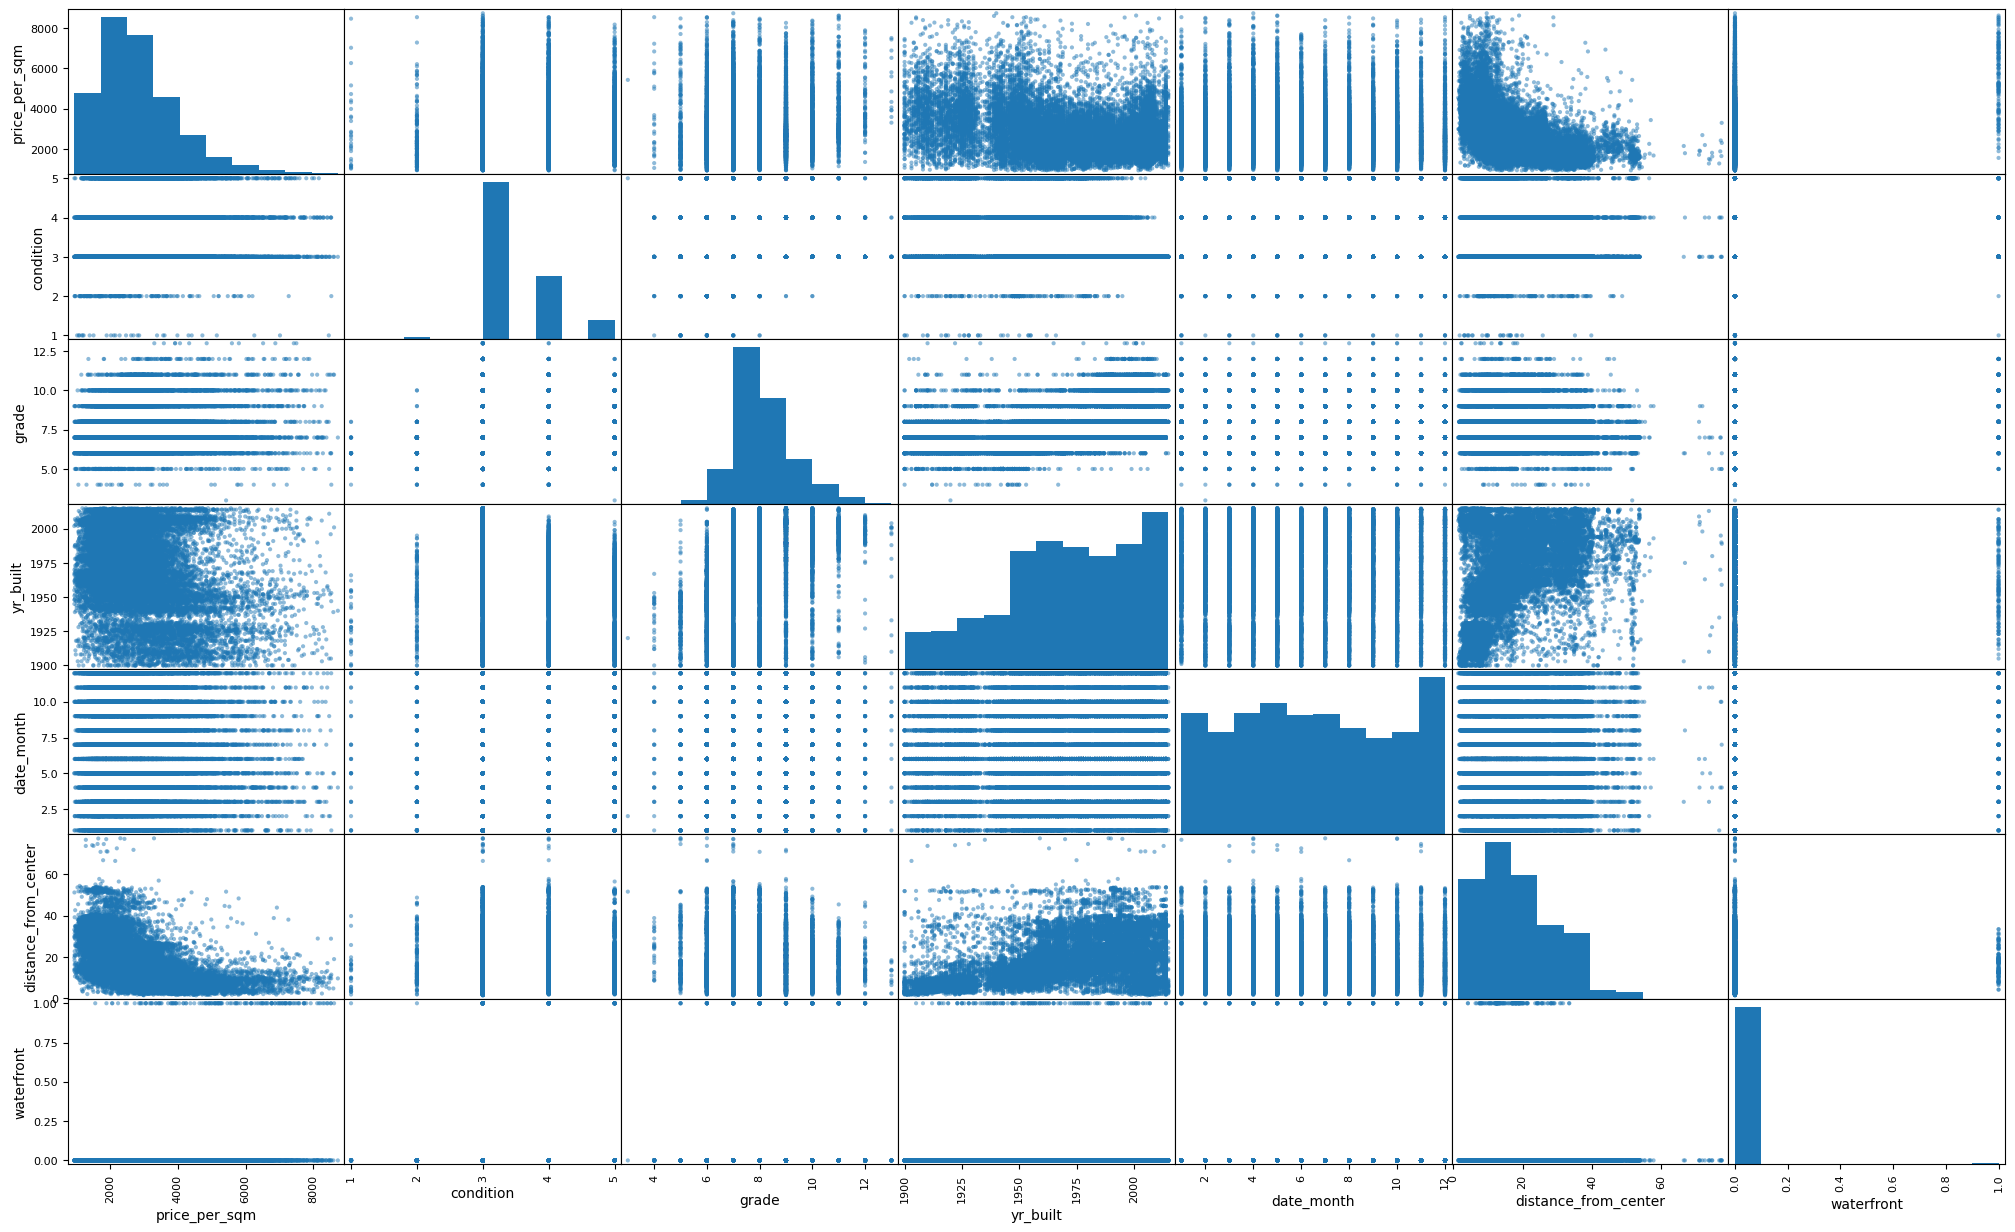

In [29]:
# Creating some variables for the regression analysis

df_reg = df.copy()
df_reg['yr_built'] = df_reg['yr_built'].dt.year
df_reg['yr_renovated'] = df_reg['yr_renovated'].dt.year
df_reg['date_yr'] = df_reg['date'].dt.year
df_reg['date_month'] = df_reg['date'].dt.month
df_reg['waterfront'] = df_reg['waterfront'].astype(int)
df_reg['basement_dummy'] = np.where(df['sqm_basement'] != 0, 1, 0)
df_reg['yr_renovated'] = df_reg['yr_renovated'].fillna(0).astype(int)
df_reg['renovation_dummy'] = (df_reg['yr_renovated'] != 0).astype(int)
reg_list = ['price_per_sqm','condition','grade','yr_built','date_month','distance_from_center','waterfront']

# take logs() of heavily skewed and exponential data

# regression analysis

Y = df_reg[reg_list[0]]
X = df_reg[reg_list[1:]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
pd.plotting.scatter_matrix(df_reg[reg_list],figsize=(25,15))
print(model.summary())



yr_built = only says that houses far from the center are newer. newer houses are a little bit more likely to have a high grade
we know that the month and year of selling has no impact on the price. dripping from OLS
a basement reduces the price of the house: spurous correlation? maybe basements are only in poor areas
basement_dummy and doesnt increase the fit of the model, therefore dropping
waterfront increases the price but has no positive impact on the houses' ratings


Creating Some plots to visualize the previous findings

In [31]:
# Grouping houses into the years they were built in. Then calculating the average price per square-meter for each year-group (for prices in 2014/15)
# Calculating the deviation of that average sqm price per year (age) to the overall average price per sqm in %.

yearly_average_ppsqm = df.groupby('yr_built')['price_per_sqm'].mean().reset_index()
df = pd.merge(df, yearly_average_ppsqm, on='yr_built', suffixes=('', '_avg'))
df['ppsqm_variation'] = (df.price_per_sqm_avg / df.price_per_sqm.mean() -1) * 100

# Variable: Deviation of the weekly average price per square-meter for each month for the total average of the observed year.

df_monthly = df.groupby(pd.Grouper(key='date', freq='M')).mean().reset_index()
df_monthly['monthly_margin'] = (df_monthly.price_per_sqm / df_monthly.price_per_sqm.mean() -1 ) * 100

In [32]:
# Price and Price per SQM for each of the 13 grading categories

fig_grade_price = px.bar(df.groupby(['grade']).mean().reset_index(),
             x='grade',
             y='price',
             title = 'ABC'
             )

fig_grade_psqm = px.bar(df.groupby(['grade']).mean().reset_index(),
             x='grade',
             y='price_per_sqm',
             title = 'ABC'
             )

# See above how the variable was calculated. Price_per_sqm deviation from the overall average for each year houses were built in % for prices in 2014/15.

fig_year = go.Scatter(
                 x=df.sort_values('yr_built').yr_built,
                 y=df.sort_values('yr_built').ppsqm_variation,
                 fill = 'tozeroy',
                 line_color = '#00CC96'
                 )

# Is the time of the year relevant for profit?
# PROBLEM: Statistical Significance? This might be true for the observed time period in retrospective but its always one year. Drawing conclusions from observing a single month for the following month is not advisable.

fig_month = px.bar(df_monthly,
             x='date',
             y='monthly_margin'
             )


# Making a subplot with the 3 plots above + making it look fancy

fig = make_subplots(rows=2, cols=2, subplot_titles=('Average price for each "Grade" of the King County grading system',
                                                    'Deviation from the average price per sqm in % per year of construction (in 2014/15 prices)',
                                                    'Average price per square-meter for each "Grade" of the King County grading system',
                                                    'Deviation from the average price per sqm in % per month it was sold in'))
fig.add_trace(fig_grade_price.data[0],1,1)
fig.add_trace(fig_grade_psqm.data[0],2,1)
fig.add_trace(fig_year,1,2)
fig.add_trace(fig_month.data[0],2,2)
fig.update_layout(
    plot_bgcolor='#292929',
    paper_bgcolor='#1F1F1F',
    font_color='#A8A8A8',
    showlegend = False,
    height=1200)

fig.update_traces(    
    marker_color = '#00CC96', marker_opacity = 1,
    marker_line_color = '#00CC96', opacity = 0.7, marker_line_width=2)

fig.update_xaxes(showline=False, showgrid = False, zerolinecolor='#3D3D3D', linecolor='#3D3D3D', gridcolor='#3D3D3D')
fig.update_yaxes(showline=False, showgrid = True, zerolinecolor='#FFFFFF', linecolor='#3D3D3D', gridcolor='#3D3D3D')

fig.update_layout(title_text="Four Subplots")
fig.update_xaxes(title_text="", row=1, col=1)
fig.update_yaxes(title_text="price in million USD", row=1, col=1)
fig.update_xaxes(title_text="", row=1, col=2)
fig.update_yaxes(title_text="Deviation from average price per sqm in %", row=1, col=2)
fig.update_xaxes(title_text="", row=2, col=1)
fig.update_yaxes(title_text="price per sqm in USD", row=2, col=1)
fig.update_xaxes(title_text="", row=2, col=2)
fig.update_yaxes(title_text="Deviation from average price per sqm in %", row=2, col=2)

fig.show()

In [33]:
df_waterfront = df.copy()

# drop all rows where the zipcode are has no waterfront houses at all
waterfront_zipcodes = df_waterfront.loc[df_waterfront['waterfront']==True, 'zipcode'].unique()
df_waterfront = df_waterfront.loc[df_waterfront['zipcode'].isin(waterfront_zipcodes)]

# group the dataframe by zipcode and whether they have a waterfront or not
df_waterfront = df_waterfront.groupby(['zipcode','waterfront']).mean().reset_index()

# change the datatype of zipcode to string so it doesnt get interpreted as a continuous scale and pass everything into a neat pivot_table
df_waterfront.zipcode = df_waterfront.zipcode.astype(str)
pivot_table = df_waterfront.pivot_table(values='price', index='zipcode', columns='waterfront')

# make a figure
fig = go.Figure()

fig.add_trace(go.Bar(x=pivot_table.index, y=pivot_table[True], name='Waterfront', marker_color='#00CC96'))
fig.add_trace(go.Bar(x=pivot_table.index, y=pivot_table[False], name='Not Waterfront', marker_color='#FFA15A'))


# from here on everything is just pretty polish
fig.update_layout(
            autosize=False,
            barmode='group',
            title='Average House Prices by Zipcode and Waterfront',
            title_x=0.5,
            legend=dict(
                title='',
                orientation='h',
                yanchor='bottom',
                y=1.02,
                xanchor='right',
                x=1
            ),
            xaxis=dict(
                categoryorder='array',
                categoryarray=pivot_table.index,
                title='Zipcode'
            ),
            xaxis_tickangle=-45,
            xaxis_title='Zipcode',
            yaxis_title='Price',
            margin=dict(l=0, r=0, t=50, b=0),
            height=600,
            width=1200,
)

fig.update_layout(
    plot_bgcolor='#292929',
    paper_bgcolor='#1F1F1F',
    font_color='#A8A8A8',)
fig.update_traces(marker_line_color='#1F1F1F',
                  marker_line_width=1, opacity=0.7,
                  )
fig.update_xaxes(showline=False, zerolinecolor='#1F1F1F', linecolor='#3D3D3D')
fig.update_yaxes(zerolinecolor='#3D3D3D', linecolor='#3D3D3D', gridcolor='#3D3D3D')

fig.show()

In [ ]:
# Maybe an extra analysis for renovated houses.

In [49]:
# Find the most average of houses in the outskirts

df_outskirts = df.query('distance_from_center >= distance_from_center.quantile(0.95)')
df_outskirts = df_outskirts.query('grade.quantile(0.60) >= grade >= grade.quantile(0.40)')
df_outskirts = df_outskirts.query('sqm_above.quantile(0.60) >= sqm_above >= sqm_above.quantile(0.40)')
df_outskirts = df_outskirts.query('price_per_sqm.quantile(0.60) >= price_per_sqm >= price_per_sqm.quantile(0.40)')
df_outskirts = df_outskirts.query('sqm_basement > 0')
df_outskirts = df_outskirts.query('sqm_lot.quantile(0.75) >= sqm_lot >= sqm_lot.quantile(0.25)')
df_outskirts.sort_values('yr_built').head(50)

# New Figure for the map
fig = go.Figure()

# Figure for the map plotting all houses left in df_outskirts
fig.add_trace(go.Scattermapbox(
        lat=df_outskirts.lat,
        lon=df_outskirts.long,
        mode='markers',
        marker=dict(
            size=15,
            color='#00CC96'
        ),
        text=df_outskirts.zipcode
    )
)

# Adding the Space Needle as reference point for the city center
fig.add_trace(go.Scattermapbox(
        lat=[CENTER[0]],
        lon=[CENTER[1]],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=14,
            color='red',
            symbol='star'
        ),
        text=['Central Business District'],
        name='Point of Interest'
))

# making everything look a little more pretty
fig.update_layout(
    mapbox_style='dark',
    mapbox=dict(
        accesstoken=accesstoken,
        center=dict(lat=47.284, lon=-122.200),
        zoom=12
    ),
    margin={'r':0,'t':0,'l':0,'b':0},
    title_text='Seattle',
    title_font_color='black',
    coloraxis_showscale=False,
    autosize=True,
    width=1200,
    height=600,
    font_family='Gravitas One',
    showlegend=False
)

fig.show()
df_outskirts.head(50)

house_id  bedrooms  bathrooms  floors  sqm_living  sqm_above  \
4798   2521059042         5      2.750   1.000     252.700    157.900   
17049  3751606785         3      2.250   1.000     191.400    148.600   

       sqm_basement   sqm_lot  waterfront  view  condition  grade   yr_built  \
4798         94.800 17968.000       False     4          4      7 1968-01-01   
17049        42.700  4396.000       False     2          4      8 1976-01-01   

      yr_renovated  zipcode    lat     long  distance_from_center  \
4798           NaT    98092 47.284 -122.121                39.763   
17049          NaT    98001 47.276 -122.265                37.576   

       sqm_living15  sqm_lot15       date      price  price_per_sqm  \
4798        262.000  23067.100 2014-11-07 456000.000       1804.511   
17049       173.700   1826.800 2014-07-22 335000.000       1750.261   

       price_per_sqm_avg  ppsqm_variation  
4798            2575.468           -9.417  
17049           2549.088          -10.345